In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.9.2


In [ ]:

! unzip '/content/drive/MyDrive/Flower_dataset.zip' -d '/content/Flower_dataset/'

In [ ]:
imgFiles = glob.glob("/content/Flower_dataset/tiny_FR/*/*.jpg") #navigate through sub-folders, parses them and store in a list
for items in imgFiles[:8]: #imgFiles is a list of strings, each string corresponds to the file path 
  print(items)

/content/Flower_dataset/tiny_FR/tulip/480228053_513791d474.jpg
/content/Flower_dataset/tiny_FR/tulip/303858799_942b9c09e7_m.jpg
/content/Flower_dataset/tiny_FR/tulip/478765271_6a8ca1cfa1_m.jpg
/content/Flower_dataset/tiny_FR/tulip/130685040_3c2fcec63e_n.jpg
/content/Flower_dataset/tiny_FR/tulip/2361075034_cf730b8682.jpg
/content/Flower_dataset/tiny_FR/tulip/14957470_6a8c272a87_m.jpg
/content/Flower_dataset/tiny_FR/tulip/497305666_b5d4348826_n.jpg
/content/Flower_dataset/tiny_FR/tulip/420216121_3ee33723d7_m.jpg


In [ ]:
print(len(imgFiles))

500


In [ ]:
X = []
y = []

for fName in imgFiles:
  
  # Prepare the dataset and populate X and y
  X_i = Image.open(fName) # tiny_FR/sunflower/1715303025_e7065327e2.jpg (500, 333)
  X_i = X_i.resize((299,299)) # To make them approriate to Xception model when using Transfer Learning 
  X_i = np.array(X_i) / 255.0 # Normalize to range 0.0 to 1.0 
  X.append(X_i)

  label = fName.split("/") # ['tiny_FR', 'sunflower', '1715303025_e7065327e2.jpg'], list containing substrings
  y_i = label[-2] # 'sunflower'
 
  y.append(y_i)

#processed all  image files and corresponding intensity values and labels stored in X and y respectively 


In [ ]:
print(set(y)) # python function that lists unique values in the list. # these are string labels

# but the network can only deal with numeric data.  

{'daisy', 'rose', 'sunflower', 'tulip', 'dandelion'}


In [ ]:
from sklearn.preprocessing import LabelEncoder
lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)
print(set(y))

print(lEncoder.classes_) #classes_ is a member variable in the class


{0, 1, 2, 3, 4}
['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [ ]:
  
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)


(500, 299, 299, 3)
(500,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (400, 299, 299, 3)
X_test_shape: (100, 299, 299, 3)



#Pretrained models require 3-channel data as input
  If using grayscale (1-channel), make the following conversion:

   
*    X_train = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train))

*    X_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))


*   print(X_train.shape)






   

   

In [ ]:
#standard scaling 
mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std

#Keras Applications

https://keras.io/api/applications/

91884032/91884032 [==============================] - 3s 0us/step


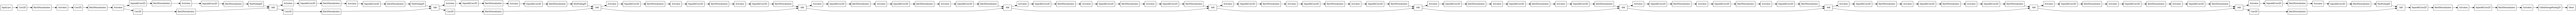

In [ ]:
# Retrieve the Xception model from Keras
#view the entire model  
Xception_model = keras.applications.Xception()

tf.keras.utils.plot_model(
    Xception_model,
    to_file='Xmodel.png',
    show_shapes=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=96
)

#For transfer learning


*   include_top=False
*   weights = 'imagenet



In [ ]:
#https://keras.io/api/applications/

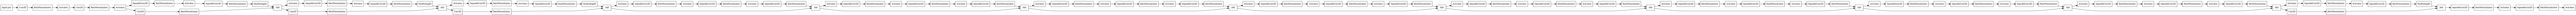

In [ ]:
# Take only the feature extractor part

base_model = keras.applications.Xception(weights='imagenet', 
                                                  include_top=False)

# Visualize the extractor part for transfer learning

tf.keras.utils.plot_model(
    base_model,
    to_file='baseModel.png',
    show_shapes=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=96
)

In [ ]:
# Make the weights/parameters of fetaure extractor non-trainable
# Freeze the weights - will not be updated during backpropagation
for layer in base_model.layers:
  layer.trainabe = False


#Add classifier part


*   Global Average Pooling - 2D
*   Output layer (5 units (because 5-class classificaiton problem)



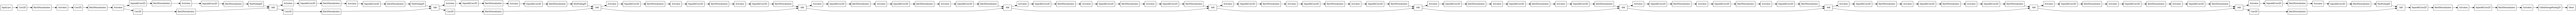

In [ ]:
# Adding classifier
#Inspect how flattening is made in the pretrained model. In Xception, they use GAP
global_pool = keras.layers.GlobalAveragePooling2D()(base_model.output)

output_ = keras.layers.Dense(units=5, activation='softmax')(global_pool)

model_TL = keras.models.Model(inputs=[base_model.input], outputs=[output_])

# Visualize the complete model
tf.keras.utils.plot_model(
    model_TL,
    to_file='Model_TL.png',
    show_shapes=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=96
)

#Compile and train the model

##Save the best weights while training

In [ ]:
model_TL.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])
#introduce callbacks to save the best model
callbacks_TL = [            
             keras.callbacks.ModelCheckpoint("bestTL.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)]



history_TL = model_TL.fit(x = X_train_std, y = y_train, epochs=50, 
                          validation_split=0.1, batch_size=16, callbacks=callbacks_TL)

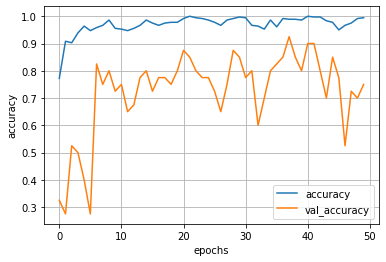

In [ ]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_TL.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

check whether to include or not, bcz accuracy discrepancies

In [ ]:
#Evaluate the model 

testLoss_TL, testAccuracy_TL = model_TL.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

4/4 [==============================] - 3s 307ms/step - loss: 0.9419 - accuracy: 0.8300
Test-loss: 0.941945, Test-accuracy: 0.830000


#Update the model with best weights


*  These weights may be from an intermediate epoch



In [ ]:
model_TL.load_weights("bestTL.h5")

testLoss_TL, testAccuracy_TL = model_TL.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

4/4 [==============================] - 1s 179ms/step - loss: 0.7654 - accuracy: 0.8000
Test-loss: 0.765378, Test-accuracy: 0.800000


#Look at the performance

In [ ]:
y_proba = model_TL.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)    
print(y_predict)

4/4 [==============================] - 1s 272ms/step
[2 3 2 0 0 3 1 2 3 4 4 1 1 1 4 1 3 0 4 1 1 3 1 2 3 0 2 1 0 4 4 4 4 2 4 2 0
 2 1 4 0 3 2 4 2 0 4 0 1 1 0 3 0 2 0 2 4 4 0 0 0 2 3 3 0 2 2 3 1 4 3 2 2 2
 3 4 4 3 0 4 1 3 1 0 0 2 1 4 3 2 0 2 4 1 1 2 1 3 2 2]


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test, y_pred = y_predict)

array([[19,  0,  0,  0,  1],
       [ 0, 19,  0,  1,  0],
       [ 0,  0, 20,  0,  0],
       [ 1,  0,  2, 16,  1],
       [ 0,  0,  2,  0, 18]])

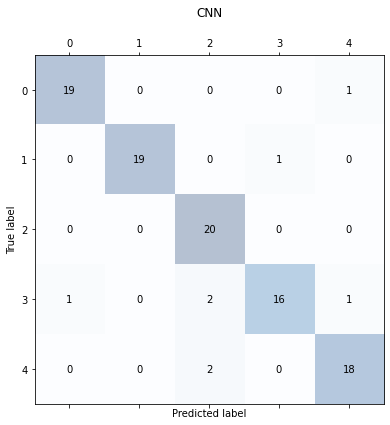

{0, 1, 2, 3, 4}
['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [ ]:
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
        
ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

print(set(y))
print(lEncoder.classes_)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

Precision:  0.9249019607843139
Recall:  0.92
F1-score:  0.9196629496629497






#Save the model & dataset(for finetuning)

In [ ]:
# Saves the best model obtained
model_TL.save('/content/drive/MyDrive/Models/01_Xception_TransferLearning_Best_Model.h5')

In [ ]:
from numpy import save

save('/content/drive/MyDrive/Models/X_train_std.npy', X_train_std)
save('/content/drive/MyDrive/Models/X_test_std.npy', X_test_std)

save('/content/drive/MyDrive/Models/y_train.npy', y_train)
save('/content/drive/MyDrive/Models/y_test.npy', y_test)